**How DETR works**


First, an image is sent through a pre-trained convolutional backbone (in the paper, the authors use ResNet-50/ResNet-101). Let’s assume we also add a batch dimension. This means that the input to the backbone is a tensor of shape (batch_size, 3, height, width), assuming the image has 3 color channels (RGB). The CNN backbone outputs a new lower-resolution feature map, typically of shape (batch_size, 2048, height/32, width/32). This is then projected to match the hidden dimension of the Transformer of DETR, which is 256 by default, using a nn.Conv2D layer. So now, we have a tensor of shape (batch_size, 256, height/32, width/32). Next, the feature map is flattened and transposed to obtain a tensor of shape (batch_size, seq_len, d_model) = (batch_size, width/32*height/32, 256). So a difference with NLP models is that the sequence length is actually longer than usual, but with a smaller d_model (which in NLP is typically 768 or higher).

Next, this is sent through the encoder, outputting encoder_hidden_states of the same shape (you can consider these as image features). Next, so-called object queries are sent through the decoder. This is a tensor of shape (batch_size, num_queries, d_model), with num_queries typically set to 100 and initialized with zeros. These input embeddings are learnt positional encodings that the authors refer to as object queries, and similarly to the encoder, they are added to the input of each attention layer. Each object query will look for a particular object in the image. The decoder updates these embeddings through multiple self-attention and encoder-decoder attention layers to output decoder_hidden_states of the same shape: (batch_size, num_queries, d_model). Next, two heads are added on top for object detection: a linear layer for classifying each object query into one of the objects or “no object”, and a MLP to predict bounding boxes for each query.

The model is trained using a bipartite matching loss: so what we actually do is compare the predicted classes + bounding boxes of each of the N = 100 object queries to the ground truth annotations, padded up to the same length N (so if an image only contains 4 objects, 96 annotations will just have a “no object” as class and “no bounding box” as bounding box). The Hungarian matching algorithm is used to find an optimal one-to-one mapping of each of the N queries to each of the N annotations. Next, standard cross-entropy (for the classes) and a linear combination of the L1 and generalized IoU loss (for the bounding boxes) are used to optimize the parameters of the model.

In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
import sys
import numba
from tqdm.autonotebook import tqdm
from accelerate import Accelerator

#MAP 
sys.path.append('../input/mean-average-precision/')
import mAP
import warnings
warnings.filterwarnings('ignore')
#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn.functional as F
#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models import resnet50

#Glob
from glob import glob

/tmp/ipykernel_19/3345297677.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import torch
from torchvision.ops.boxes import box_area


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)


# modified from torchvision to also return the union
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union


def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area


def masks_to_boxes(masks):
    """Compute the bounding boxes around the provided masks

    The masks should be in format [N, H, W] where N is the number of masks, (H, W) are the spatial dimensions.

    Returns a [N, 4] tensors, with the boxes in xyxy format
    """
    if masks.numel() == 0:
        return torch.zeros((0, 4), device=masks.device)

    h, w = masks.shape[-2:]

    y = torch.arange(0, h, dtype=torch.float)
    x = torch.arange(0, w, dtype=torch.float)
    y, x = torch.meshgrid(y, x)

    x_mask = (masks * x.unsqueeze(0))
    x_max = x_mask.flatten(1).max(-1)[0]
    x_min = x_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    y_mask = (masks * y.unsqueeze(0))
    y_max = y_mask.flatten(1).max(-1)[0]
    y_min = y_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    return torch.stack([x_min, y_min, x_max, y_max], 1)

In [3]:
from scipy.optimize import linear_sum_assignment
    
class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network

    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher

        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching

        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates

            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates

        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


In [4]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
    
class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        num_boxes = torch.clamp(num_boxes, min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [6]:
n_folds = 5
seed = 1001
num_classes = 2 #wheat+background
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 16
LR = 1e-5
lr_backbone = 1e-4
EPOCHS = 45

In [7]:
# AS PER COMPETITION METRIC
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

# Seed Everything

Seeding everything for reproducible results

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
seed_everything(seed)

# Preparing the Data

* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [10]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [11]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [12]:
def get_train_transforms():
    return A.Compose(
        [   A.OneOf([

                A.RandomBrightnessContrast(brightness_limit=0.2,  
                                           contrast_limit=0.2, p=0.3),
                A.RGBShift(r_shift_limit=20/255, g_shift_limit=20/255, b_shift_limit=10/255,p=0.3),
            ], p=0.2),
            A.OneOf([
                A.RandomGamma(gamma_limit=(80, 120), p=0.3),
#                 A.Blur(p=0.6),
                A.GaussNoise(var_limit=(0.01, 0.05), mean=0, p=0.05),
                A.ToGray(p=0.05)], p=0.2),

            A.OneOf([
                A.HorizontalFlip(p=1), 
                A.VerticalFlip(p=1),  
                A.Transpose(p=1),                
                A.RandomRotate90(p=1)], p=1),         
#               
             A.Resize(height=512, width=512, p=1.0),

             ToTensorV2(p=1.0),
             ],
             
        p=1.0, bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
    )

In [13]:
def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* DETR accepts data in coco format which is (x,y,w,h). So now we need to prepare data in that format

In [14]:
def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        normalized_bboxes.append(normalized_bbox)
    return np.array(normalized_bboxes)


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return np.array(denormalized_bboxes)

In [15]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
#         print(sample['bboxes'])
#         hhghg
        boxes = normalize_bbox(sample['bboxes'],rows=h,cols=w)
        sample['bboxes']
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

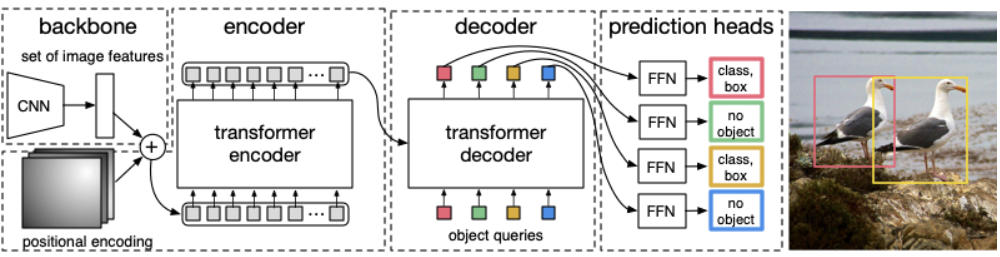

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [16]:
from typing import Optional
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self,src):
        q = k = src
        src2 = self.self_attn(q, k, value=src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src



class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src):
        output = src

        for layer in self.layers:
            output = layer(output)

        if self.norm is not None:
            output = self.norm(output)

        return output
import copy
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [17]:
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt, memory):
        output = tgt

        for layer in self.layers:
            output = layer(output, memory)

        return output

class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, tgt, memory):
        q = k = tgt
        tgt2 = self.self_attn(q, k, value=tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=tgt,
                                   key=memory,
                                   value=memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

In [18]:
class Transformer(nn.Module):

    def __init__(self, d_model=256, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers)


        self.d_model = d_model
        self.nhead = nhead



    def forward(self, src, tgt):
        memory = self.encoder(src)
        hs = self.decoder(tgt, memory)
        return hs

In [19]:
class DETRModel(nn.Module):
    """
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    """
    def __init__(self, num_classes,num_queries, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = Transformer()

        self.linear_class = nn.Linear(hidden_dim, num_classes)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
#         k_v = pos + 0.1 * h.flatten(2).permute(2, 0, 1)
#         print(k_v.size(),self.query_pos.unsqueeze(1).size())

        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1).repeat(1, x.size(0), 1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}
    

# Comp Metric

In [20]:
def calculate_final_score(all_predictions, score_threshold,form):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = mAP.calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form=form)
        final_scores.append(image_precision)

    return np.mean(final_scores)

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [21]:
'''
code taken from github repo detr , 'code present in engine.py'
'''
matcher = HungarianMatcher()

weight_dict = {'loss_ce': 0.5, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [22]:
def train_fn(data_loader,model,criterion,optimizer,device,accelerator,st,epoch,max_norm=0.1):
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    bbox_loss = AverageMeter()
    giou_loss = AverageMeter()
    labels_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(torch.stack(images))
        
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        accelerator.log({"total_loss_step": losses.item()}, step=st)
        accelerator.log({'loss_bbox': loss_dict['loss_bbox'].item()}, step=st)
        accelerator.log({'loss_giou': loss_dict['loss_giou'].item()}, step=st)
        accelerator.log({'loss_ce': loss_dict['loss_ce'].item()}, step=st)
        total_loss.update(losses.item(),BATCH_SIZE)
        bbox_loss.update(loss_dict['loss_bbox'].item())
        giou_loss.update(loss_dict['loss_giou'].item())
        labels_loss.update(loss_dict['loss_ce'].item())
        st+=1
        tk0.set_postfix(bbox_loss=bbox_loss.avg,giou_loss = giou_loss.avg,labels_loss = labels_loss.avg,total_loss=total_loss.avg)
        
    return total_loss,st

# Eval Function

In [23]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    all_predictions = []
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(torch.stack(images))

            for i in range(len(images)):
                boxes = output['pred_boxes'][i].detach().cpu().numpy()
                scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                
                _,h,w = images[i].shape
                boxes = np.array([[x,y,w,h] for x,y,w,h in denormalize_bbox(boxes,h,w)]).astype(np.int32)
                gt_boxes = np.array([[x,y,w,h] for x,y,w,h in denormalize_bbox(gt_boxes,h,w)]).astype(np.int32)

                all_predictions.append({
                    'pred_boxes': boxes,
                    'scores': scores,
                    'gt_boxes': gt_boxes,
                    'image_id': image_ids[i],
                })        

    return all_predictions

# Engine

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [25]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
    del state_dict['linear_class.weight']
    del state_dict['linear_class.bias']
    model.load_state_dict(state_dict,strict=False)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    
    accelerator = Accelerator(
        log_with="tensorboard", project_dir="."
    )
    #     accelerator = Accelerator(mixed_precision='bf16')

    accelerator.init_trackers(f"detr_project")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #weight_decay=1e-4
    
    best_map =  0
    st = 0
    for epoch in range(EPOCHS):
        train_loss,st = train_fn(train_data_loader, model,criterion, optimizer,device,accelerator,st,epoch=epoch)
        predictions = eval_fn(valid_data_loader, model,criterion, device)
        
        valid_map_score = calculate_final_score(predictions,0.5,form='coco')

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_MAP_SCORE {}|'.format(epoch+1,train_loss.avg,valid_map_score))

        if valid_map_score > best_map:
            best_map = valid_map_score
            print('Best model for Fold {} found in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')
    accelerator.end_training()
    

**Need extremely long training to converge, vs epochs for Faster FRCNN**

In [26]:
run(fold=0)

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:00<00:00, 220MB/s]
2025-06-29 11:09:31.097117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751195371.286400      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751195371.338124      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.5359621654600786| VALID_MAP_SCORE 0.009264533585500688|
Best model for Fold 0 found in Epoch 1........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 1.3993374081052972| VALID_MAP_SCORE 0.011380392933123262|
Best model for Fold 0 found in Epoch 2........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 1.3652358979163086| VALID_MAP_SCORE 0.013836160326316719|
Best model for Fold 0 found in Epoch 3........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 1.3342445538594172| VALID_MAP_SCORE 0.01487755145073021|
Best model for Fold 0 found in Epoch 4........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 1.306293492486491| VALID_MAP_SCORE 0.020884292357411433|
Best model for Fold 0 found in Epoch 5........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 1.2787895795156266| VALID_MAP_SCORE 0.02440968383196305|
Best model for Fold 0 found in Epoch 6........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 1.2470507699356983| VALID_MAP_SCORE 0.03312736114101262|
Best model for Fold 0 found in Epoch 7........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 1.214432017337641| VALID_MAP_SCORE 0.03967627176781711|
Best model for Fold 0 found in Epoch 8........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 1.1847045788398156| VALID_MAP_SCORE 0.04876046337230105|
Best model for Fold 0 found in Epoch 9........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 1.1597279373710678| VALID_MAP_SCORE 0.05936739962784242|
Best model for Fold 0 found in Epoch 10........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 1.1234183473699897| VALID_MAP_SCORE 0.07060220053700196|
Best model for Fold 0 found in Epoch 11........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 1.0899012413250624| VALID_MAP_SCORE 0.08518688313247942|
Best model for Fold 0 found in Epoch 12........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 13| TRAIN_LOSS 1.0595697898131151| VALID_MAP_SCORE 0.10455799489784286|
Best model for Fold 0 found in Epoch 13........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 14| TRAIN_LOSS 1.0340928026204983| VALID_MAP_SCORE 0.11475326693235774|
Best model for Fold 0 found in Epoch 14........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 15| TRAIN_LOSS 1.0077986008316808| VALID_MAP_SCORE 0.1394144416746072|
Best model for Fold 0 found in Epoch 15........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 16| TRAIN_LOSS 0.9863101346252938| VALID_MAP_SCORE 0.15751208134403918|
Best model for Fold 0 found in Epoch 16........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 17| TRAIN_LOSS 0.9624696437423751| VALID_MAP_SCORE 0.17811720633687|
Best model for Fold 0 found in Epoch 17........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 18| TRAIN_LOSS 0.9423680397180411| VALID_MAP_SCORE 0.18617884571792914|
Best model for Fold 0 found in Epoch 18........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 19| TRAIN_LOSS 0.9227120915108179| VALID_MAP_SCORE 0.2034023865517888|
Best model for Fold 0 found in Epoch 19........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 20| TRAIN_LOSS 0.9085672525964545| VALID_MAP_SCORE 0.21598568824964282|
Best model for Fold 0 found in Epoch 20........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 21| TRAIN_LOSS 0.8926763037252708| VALID_MAP_SCORE 0.22799677805731378|
Best model for Fold 0 found in Epoch 21........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 22| TRAIN_LOSS 0.879914404725182| VALID_MAP_SCORE 0.24216309750244616|
Best model for Fold 0 found in Epoch 22........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 23| TRAIN_LOSS 0.865462059452689| VALID_MAP_SCORE 0.2540978322292145|
Best model for Fold 0 found in Epoch 23........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 24| TRAIN_LOSS 0.8544564412895744| VALID_MAP_SCORE 0.25861599977135086|
Best model for Fold 0 found in Epoch 24........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 25| TRAIN_LOSS 0.844426290523371| VALID_MAP_SCORE 0.27101803849609657|
Best model for Fold 0 found in Epoch 25........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 26| TRAIN_LOSS 0.8321357595144644| VALID_MAP_SCORE 0.2793766252124263|
Best model for Fold 0 found in Epoch 26........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 27| TRAIN_LOSS 0.8243788046949714| VALID_MAP_SCORE 0.2817976518585165|
Best model for Fold 0 found in Epoch 27........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 28| TRAIN_LOSS 0.8144712797283421| VALID_MAP_SCORE 0.30385950010650786|
Best model for Fold 0 found in Epoch 28........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 29| TRAIN_LOSS 0.8087154492824036| VALID_MAP_SCORE 0.3017325632680257|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 30| TRAIN_LOSS 0.8019746926409252| VALID_MAP_SCORE 0.31015696632713663|
Best model for Fold 0 found in Epoch 30........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 31| TRAIN_LOSS 0.7957204816609444| VALID_MAP_SCORE 0.31654403709621654|
Best model for Fold 0 found in Epoch 31........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 32| TRAIN_LOSS 0.7883293395917091| VALID_MAP_SCORE 0.323819081876771|
Best model for Fold 0 found in Epoch 32........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 33| TRAIN_LOSS 0.7829649645901291| VALID_MAP_SCORE 0.32609966233577165|
Best model for Fold 0 found in Epoch 33........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 34| TRAIN_LOSS 0.7781599650721578| VALID_MAP_SCORE 0.3318267361480028|
Best model for Fold 0 found in Epoch 34........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 35| TRAIN_LOSS 0.771016025684289| VALID_MAP_SCORE 0.33938854693377474|
Best model for Fold 0 found in Epoch 35........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 36| TRAIN_LOSS 0.7676035264540001| VALID_MAP_SCORE 0.3357738124321143|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 37| TRAIN_LOSS 0.7616306624468967| VALID_MAP_SCORE 0.33862250978772046|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 38| TRAIN_LOSS 0.7571321962147775| VALID_MAP_SCORE 0.3487713837512065|
Best model for Fold 0 found in Epoch 38........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 39| TRAIN_LOSS 0.75075158423926| VALID_MAP_SCORE 0.34901786577872496|
Best model for Fold 0 found in Epoch 39........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 40| TRAIN_LOSS 0.7462834345518484| VALID_MAP_SCORE 0.3618804941676243|
Best model for Fold 0 found in Epoch 40........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 41| TRAIN_LOSS 0.743437610081667| VALID_MAP_SCORE 0.35636424293352165|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 42| TRAIN_LOSS 0.7410410413375268| VALID_MAP_SCORE 0.3593372986353526|


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 43| TRAIN_LOSS 0.7364614725818296| VALID_MAP_SCORE 0.3648225964537316|
Best model for Fold 0 found in Epoch 43........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 44| TRAIN_LOSS 0.7316560808723495| VALID_MAP_SCORE 0.37073660214807436|
Best model for Fold 0 found in Epoch 44........Saving Model


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

|EPOCH 45| TRAIN_LOSS 0.7281925202121396| VALID_MAP_SCORE 0.37311915829757725|
Best model for Fold 0 found in Epoch 45........Saving Model


In [27]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))

<All keys matched successfully>

In [28]:

df_valid = df_folds[df_folds['fold'] == 0]
valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
valid_data_loader = DataLoader(
                                valid_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                               num_workers=4,
                               collate_fn=collate_fn)

images, targets, image_ids = next(iter(valid_data_loader))
# _,h,w = images[0].shape # for de normalizing images
device=torch.device('cuda')
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [29]:
def view_sample(images, targets, image_ids,model,device):
    
    _,h,w = images.shape # for de normalizing images
    
    boxes = targets['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in denormalize_bbox(boxes,h,w)]
    sample = images.permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images.unsqueeze(0))
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = denormalize_bbox(oboxes, rows=h, cols=w)
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        
        if p >0.55:
            color = (0,1,0) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]+box[0]), int(box[3]+box[1])),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

**Red-Original**


**Green-predicted**

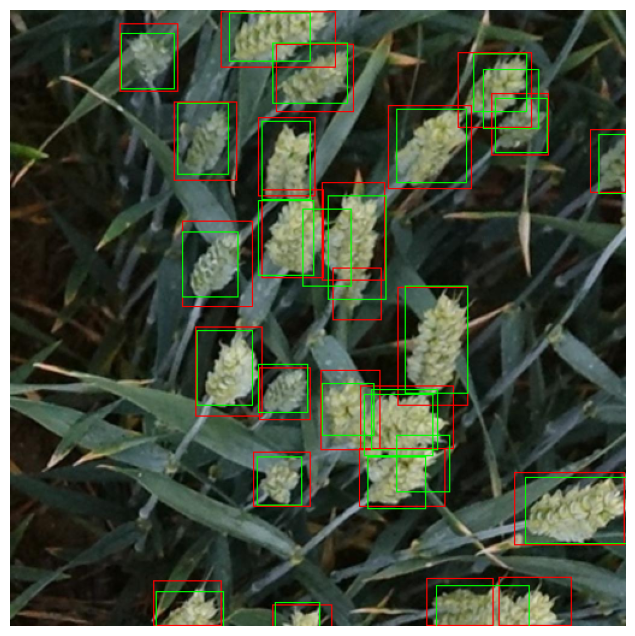

In [30]:
view_sample(images[0], targets[0], image_ids[0],model,device)

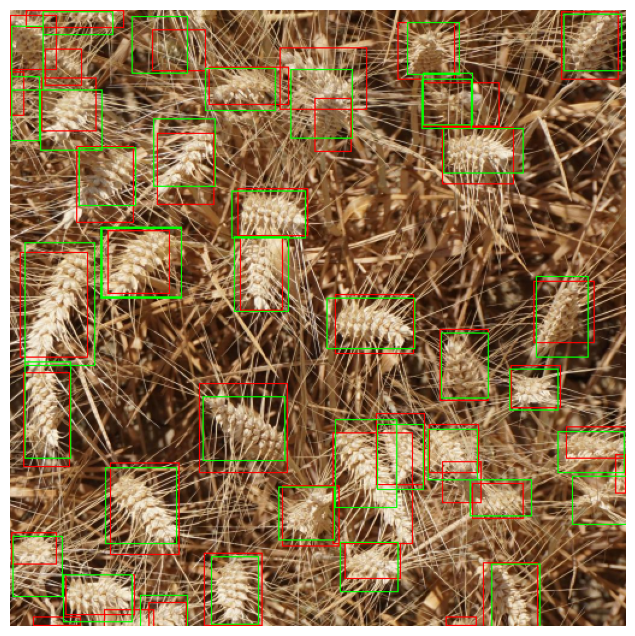

In [31]:
view_sample(images[1], targets[1], image_ids[1],model,device)

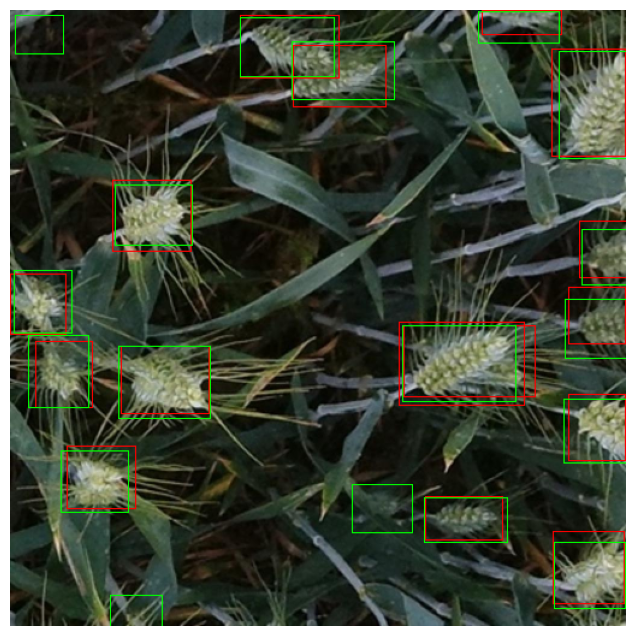

In [32]:
view_sample(images[2], targets[2], image_ids[2],model,device)

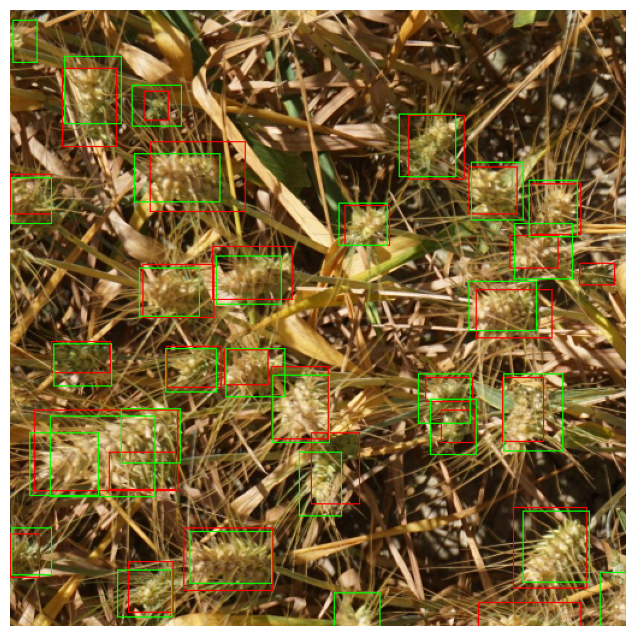

In [33]:
view_sample(images[3], targets[3], image_ids[3],model,device)

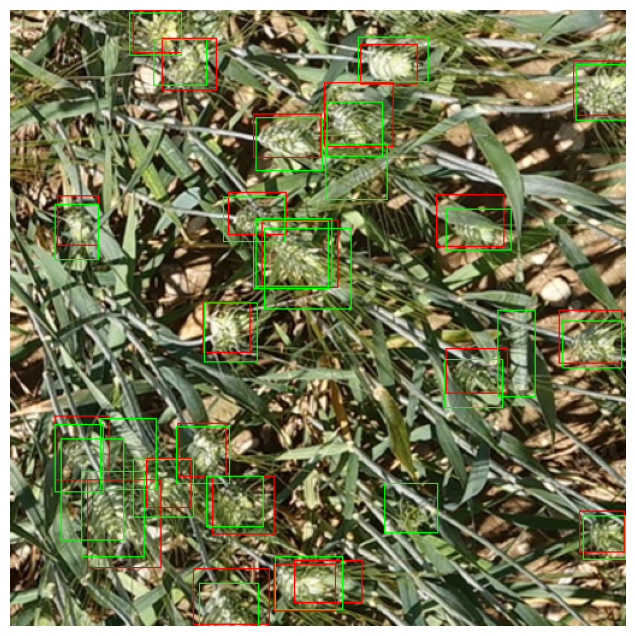

In [34]:
view_sample(images[4], targets[4], image_ids[4],model,device)

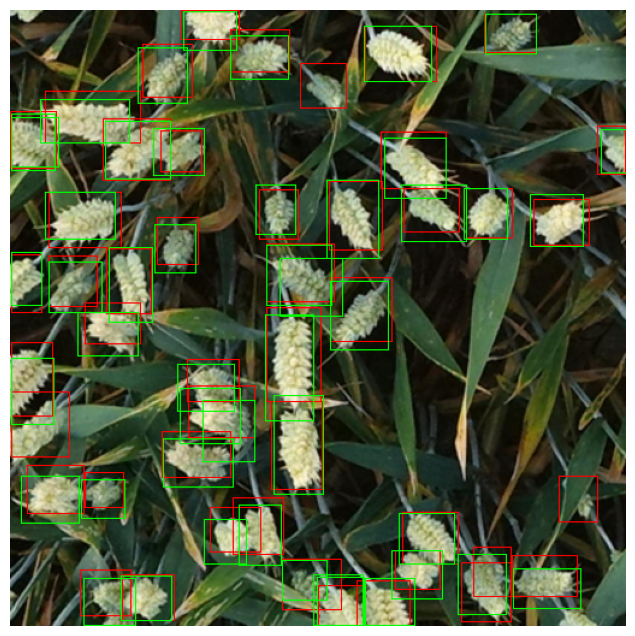

In [35]:
view_sample(images[5], targets[5], image_ids[5],model,device)

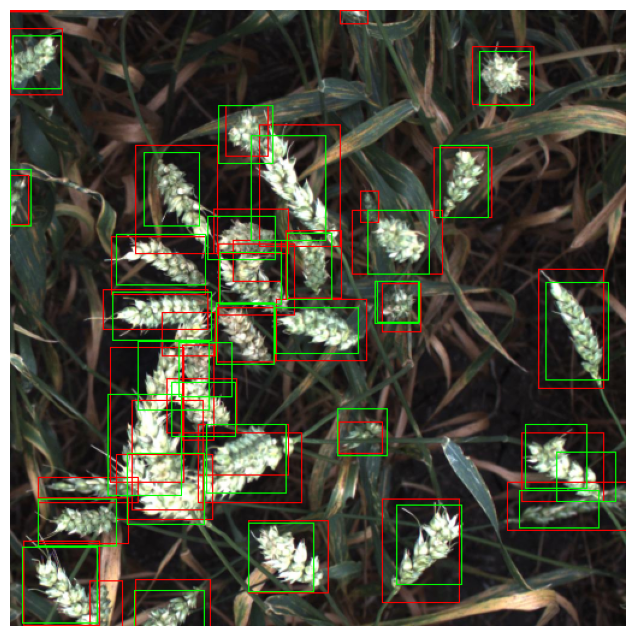

In [36]:
view_sample(images[6], targets[6], image_ids[6],model,device)